<a href="https://colab.research.google.com/github/laurenbchu/LEGALST-123/blob/main/%5BTeam_4%5D_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UC Berkeley WarnMe Accuracy Analysis: Brief**
 The aim of our team’s research was to discover whether or not UC Berkeley’s WarnMe system – which sends automated email alerts to Cal students when crime-related incidents occur on campus and around Berkeley – accurately reflects the incidence of criminal activity around Berkeley. We arrived at our research question in part through in-class discussions of how particular geographic areas come to be overrepresented in crime reports. In particular, given the amount of WarnMe alerts students receive pertaining to the area in and around People’s Park, we were curious to know whether or not criminal activity in that area was accurately represented by said alerts. Additionally, a Daily Cal article published in June of 2023 which examined the timeliness of WarnMe alerts brought to our attention another layer of accuracy to examine: temporal accuracy. Thus we set out to compare the WarnMe alerts to reported Berkeley crime, with the goal of assessing their geographic, temporal, and typological (as in, incident-type) accuracy.

To conduct our research, we gathered both WarnMe alerts (sent between August of 2021 and October of 2023) and UCPD Crime Logs (records representing crime-related incidents reported to UCPD from January of 2019 to January 2024). After thoroughly cleaning our data to eliminate incomplete entries – a significant but not concerning number in the case of the crime log data, due to the human officer-driven data collection process – and irrelevant variables, we conducted an exploratory data analysis. Our initial examination of the geographic distribution of crime throughout Berkeley, as reported by the UCPD’s 2021-2023 Crime Logs, is represented by the bar chart below.
Interestingly enough, this initial horizontal bar chart does indicate that People’s Park accounts for the majority of crime-related incidents reported to the UCPD during the years studied. Between the People’s Park location and the People’s Park Housing Construction Site, roughly 325 entries in the crime logs are accounted for, or about 3.6% of the total number of entries in the logs across 2021-2023. Thus, our initial geographic findings seem to indicate that perhaps the WarnMe alerts of our collective memory are not biased towards People’s Park, or at least not any more than the UCPD crime logs are.

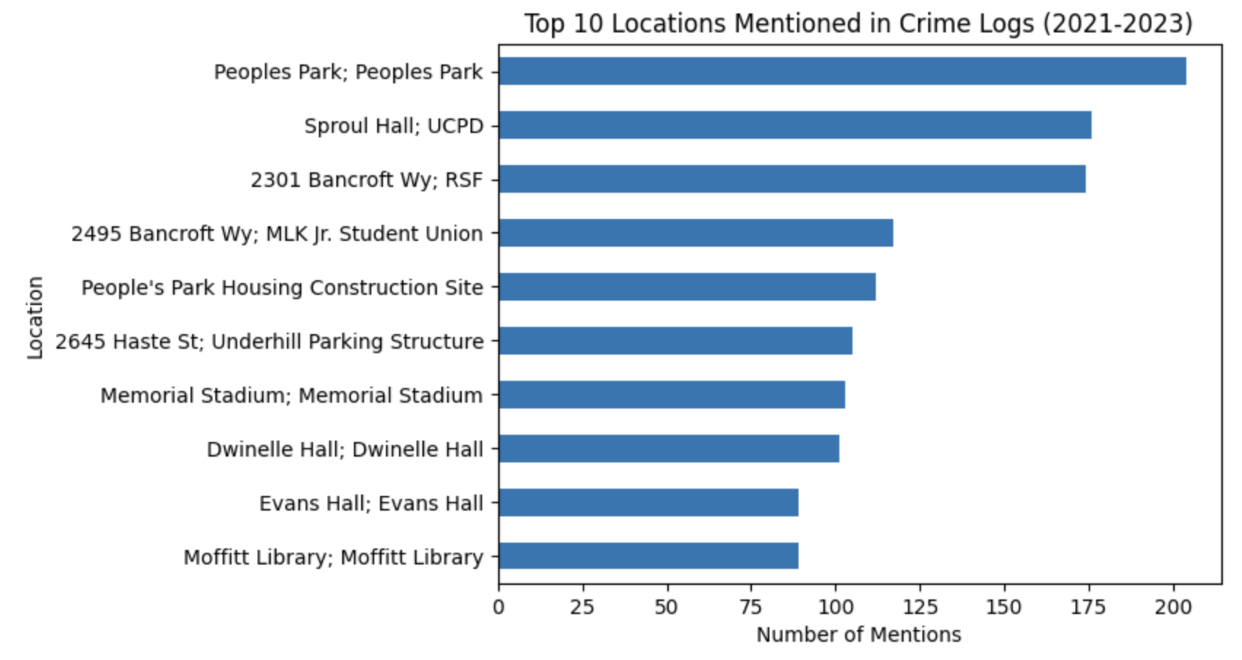

Next, our EDA examined incident typology and frequency, compared across the WarnMe alerts and the UCPD crime logs. Our findings are depicted below.

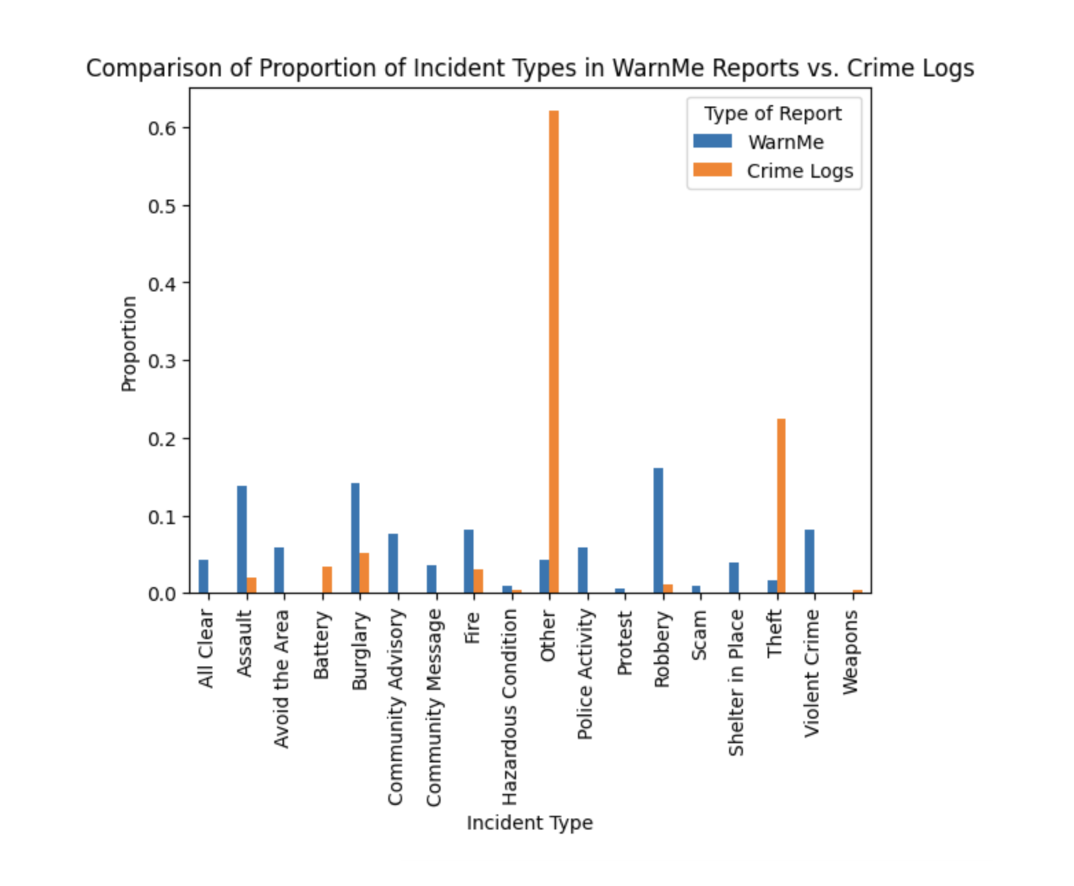

Perhaps due to the human officer-dependent nature of the crime logs’ data-generating process, the Crime Logs contain many more entries classified as “Other”; on the other hand, were the majority of WarnMe alerts to be classed as “Other,” they would hardly be informative, and thus the low proportion of WarnMes in the “Other” type makes sense. In addition to the “Other” category, there are large proportional discrepancies between the Crime Logs and the WarnMes in the “Assault” and “Theft” categories, and smaller differences in the “Police Activity,” “Protest,” “Avoid the Area,” and “Violent Crime” categories. The discrepancies in the proportional representation is likely in part due to the differing sizes of the data sets, and likely also in part due to the differing typologies that the Crime Logs and WarnMes use to classify crime-related incidents. Additionally, the UCPD likely has little use for independent categories such as “Police Activity” – as they are the police – and “Avoid the Area” – as they are likely issuing those “Avoid the Area” advisories. Due to these discrepancies in how incidents are recorded in the two datasets, we concluded that the best way to compare them and thus assess the accuracy of the WarnMe alerts was to match the WarnMe records of specific incidents with their most-probable Crime Log counterparts.

It was this table – which matched the WarnMe entries and Crime Log entries on the basis of geographic location and time stamps – that we used to model the temporal and typological accuracy of the WarnMes.

Beginning with the temporal accuracy of the WarnMe alerts, we modeled the difference between an incident report being filed with the UCPD and an accompanying WarnMe sent out in the below violin plot.

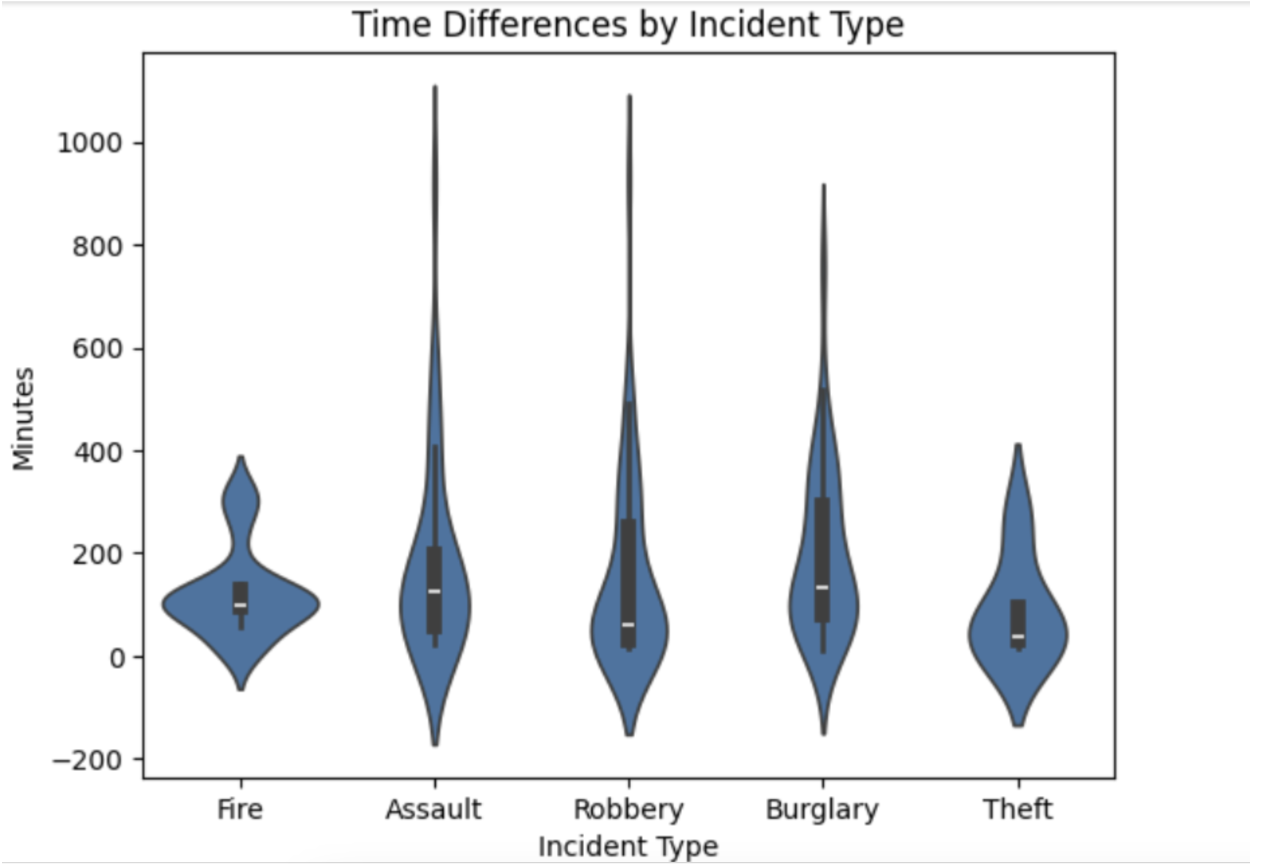

Unsurprisingly, “Fire”-related incidents in which time is of the essence, had the lowest-value elapsed time between the filing of an incident report and an accompanying WarnMe. “Theft” incidents came next closest in terms of accuracy, which ostensibly makes sense as those incidents often occurred on and around campus. Overall, the median elapsed time between the filing of a Crime Log entry and an accompanying WarnMe was between 0 and 150 minutes across the five represented incident categories, with the outliers in the “Assault,” “Robbery,” and “Burglary” categories representing over 1000, 1000, and 900 minutes of elapsed time, respectively.

We also modeled the typological accuracy of the WarnMe alerts, using a predictive LDA model to see whether topic clouds associated with each incident category (Fire, Assault, Robbery, Burglary, Theft, Violent Crime, and Hazardous Condition) could be created using the title text and body text of the alerts with corresponding Crime Log entries. Although the LDA model was able to predict some topic categories that appeared to be centered on one incident type, such as burglaries, in general too many of the word tokens generated from the WarnMe alerts’ text contained location information. Even with tokens representing common locations such as “univers,” “berkeley,” and “park” removed from the model, the volume of matching WarnMe-Crime Log entries required the model to iterate seven times over the data set of 176 entries. Thus, the LDA model was unable to produce coherent incident-type correspondent topics.



# **UC Berkeley WarnMe Accuracy Analysis: Data Life Cycle**

Through this notebook, our team explores the extent to which UC Berkeley WarnMe alerts reflect the actual criminal activity around the Berkeley campus, via geographical distribution analysis, timeliness of WarnMe alerts, and the accuracy of crime reporting descriptions, in terms of representing actual Berkeley crime according to the UCPD Daily Crime Logs.

**Dependencies:**

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from geopy.geocoders import Nominatim
from multiprocessing import Pool
import folium
from folium.plugins import HeatMap
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
!pip install gensim
from gensim import corpora, models
!pip install pyldavis

----
## **The Data**

We rely on two main datasets: the UCPD Daily Crime Logs and the UC Berkeley WarnMe alerts.

**Crime Logs**: After reaching out to the UCPD, we gained access to PDFs of crime logs from January 2019 to January 2024, which include details about the date/time, case number, category, incident description, location, synopsis, and disposition for each logged crime.

**WarnMes**: We also reached out to the university and received the WarnMe records from August 2nd, 2021 to October 19th, 2023 in PDF format with the categories Message Body, Message Title, and Sent On.

Both of our datasets were given in PDF format, so we had to first convert the data to a csv file, which is imported here. For ease of categorization, we split the crime log entries by year: 2021, 2022, and 2023.

**Importing the Data:**

In [ ]:
# Importing the ability to pull files directly from Google Drive
drive.mount('/content/drive')

# Defining the path to pull my specific file
#os.chdir('/content/drive/My Drive/LEGALST 123 Project')
os.chdir('/content/drive/My Drive/LEGALST 123/LEGALST 123 Project')

# Load the XLSX file into a DataFrame
# These are all of the WarnMes from August 2nd, 2021 to October 19th, 2023
warnme = pd.read_excel('WarnMe Records.xlsx')

# Load in the excel sheets for the 2021, 2022, and 2023 UCPD Daily Crime Log data
twentyone = pd.read_excel('Crime Log 2021.xlsx')
twentytwo = pd.read_excel('Crime Log 2022.xlsx')
twentythree = pd.read_excel('Crime Log 2023.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----

## Section 1: Exploratory Data Analysis

Some of the crime log entries from certain years include typos. For example, the 2021 crime logs have a column named "Locations" instead of "Location" like the other crime logs, and the 2022 crime logs have a column named "Occurred Range" with a space at the end that messes up our merging. As such, we clean up the columns names below.

In [ ]:
# Change the column names so that each year's reports match
twentyone.rename(columns={'Locations': 'Location'}, inplace=True)
twentytwo.rename(columns={'Occurred Range ': 'Occurred Range'}, inplace=True)

In order to aid in preliminary data exploration and later visualization, we utilize keyword patterns and regular expressions to categorize each warnme incident as a certain type of incident. The options are: Robbery, Burglary, Assault, Violent Crime, Fire, Police Activity, Hazardous Condition, Theft, All Clear, Scam, Protest, Avoid the Area, Community Advisory, Community Message, Shelter in Place, and Other.

In [ ]:
# Create a new column to store the identified incident type
warnme['Incident Type'] = ''

# Define keyword patterns and regular expressions for each type of incident
incident_patterns = {
    'Robbery': r'\b(robbery)\b',
    'Burglary': r'\b(burglary)\b|\b(burglaries)\b',
    'Assault': r'\b(assault)\b|\b(aggravated assault)\b|\b(sexual assault)\b',
    'Violent Crime': r'\b(violent crime)\b',
    'Fire': r'\b(fire)\b',
    'Police Activity': r'\b(police activity)\b',
    'Hazardous Condition': r'\b(hazardous condition)\b|\b(gas)\b',
    'Theft': r'\b(theft)\b',
    'All Clear': r'\b(all clear)\b|\b(area clear)\b',
    'Scam': r'\b(scam)\b',
    'Protest': r'\b(protest)\b',
    'Avoid the Area': r'\b(avoid the area)\b'
}

# Iterate through each row and identify the type of incident
for index, row in warnme.iterrows():
    message = row['Message Body'].lower()
    for incident_type, pattern in incident_patterns.items():
        if re.search(pattern, message):
            warnme.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Filter rows where the 'Incident Type' column is empty
empty = warnme[warnme['Incident Type'] == '']

# Define keyword patterns and regular expressions for each type of incident
keywords = {
    'Violent Crime': r'\b(violent crime)\b',
    'Community Advisory': r'\b(community advisory)\b',
    'Community Message': r'\b(community message)\b',
    'Shelter in Place': r'\b(shelter in place)\b'
}

# Iterate through each row with empty incident type and identify the type of incident using message title
for index, row in empty.iterrows():
    if pd.notnull(row['Message Title']):  # Check if message title exists
        message_title = row['Message Title'].lower()
        for incident_type, pattern in keywords.items():  # Iterate over keywords
            if re.search(pattern, message_title):
                warnme.at[index, 'Incident Type'] = incident_type
                break  # Once a match is found, no need to check further

# Classify the remaining alerts as general Community Advisory or Community Message
final_patterns = {
    'Community Advisory': r'\b(community advisory)\b',
    'Community Message': r'\b(community message)\b',
}

still_empty = warnme[warnme['Incident Type'] == '']
# Iterate through each row and identify the type of incident
for index, row in still_empty.iterrows():
    message = row['Message Body'].lower()
    for incident_type, pattern in final_patterns.items():
        if re.search(pattern, message):
            warnme.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Assign everything else to Other
warnme.loc[warnme['Incident Type'] == '', 'Incident Type'] = 'Other'

Now having classified each WarnMe event with an incident type, we count the frequencies of each incident type below and produce a summary table.

In [ ]:
# Count the frequency of each incident type
incident_counts = warnme['Incident Type'].value_counts()

# Create a summary table
warnme_summary = pd.DataFrame({
    'Incident Type Counts': incident_counts
})

warnme_summary['Proportion of All Messages'] = warnme_summary['Incident Type Counts'] / len(warnme)
warnme_summary

,Incident Type Counts,Proportion of All Messages
Incident Type,,
Robbery,49,0.160656
Burglary,43,0.140984
Assault,42,0.137705
Fire,25,0.081967
Violent Crime,25,0.081967
Community Advisory,23,0.075410
Police Activity,18,0.059016
Avoid the Area,18,0.059016
Other,13,0.042623


Next, we combine the 2021, 2022, and 2023 crime logs into one large dataframe of all of the crime log entires, in a DataFrame called "crimelog". Then, just as we did above with the WarnMes, we categorize each crime log entry as an incident type. The incident types are: Robbery, Burglary, Assault, Battery, Violent Crime, Fire, Police Activity, Hazardous Condition, Theft, All Clear, Scam, Protest, Avoid the Area, Weapons, and Other.

In [ ]:
# concatenate 2021, 2022, and 2023 crime logs
crimelog = pd.concat([twentyone, twentytwo, twentythree], ignore_index=True)

# Clean and condense crime categories
# Create a new column to store the identified incident type
crimelog['Incident Type'] = ''

# Define keyword patterns and regular expressions for each type of incident in Crime Log that corresponds with WarnMe
incident_patterns = {
    'Robbery': r'\b(robbery)\b',
    'Burglary': r'\b(burglary)\b|\b(burglaries)\b',
    'Assault': r'\b(assault)\b|\b(aggravated assault)\b|\b(sexual assault)\b|\b(rape)\b',
    'Battery': r'\b(battery)\b',
    'Violent Crime': r'\b(violent crime)\b',
    'Fire': r'\b(fire)\b',
    'Police Activity': r'\b(police activity)\b',
    'Hazardous Condition': r'\b(hazardous condition)\b|\b(gas)\b',
    'Theft': r'\b(theft)\b',
    'All Clear': r'\b(all clear)\b|\b(area clear)\b',
    'Scam': r'\b(scam)\b',
    'Protest': r'\b(protest)\b',
    'Avoid the Area': r'\b(avoid the area)\b',
    'Weapons':r'\b(weapon)\b',
}

crimelog['Crime(s)'] = crimelog['Crime(s)'].astype(str)

# Iterate through each row and identify the type of incident
for index, row in crimelog.iterrows():
    message = row['Crime(s)'].lower()
    for incident_type, pattern in incident_patterns.items():
        if re.search(pattern, message):
            crimelog.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Filter rows where the 'Incident Type' column is empty
empty = crimelog[crimelog['Incident Type'] == '']


still_empty = crimelog[crimelog['Incident Type'] == '']
# Iterate through each row and identify the type of incident
for index, row in still_empty.iterrows():
    message = row['Crime(s)'].lower()
    for incident_type, pattern in final_patterns.items():
        if re.search(pattern, message):
            crimelog.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Assign everything else to Other
crimelog.loc[crimelog['Incident Type'] == '', 'Incident Type'] = 'Other'

Now having classified each crime log entry with an incident type, we count the frequencies of each incident type below and produce a summary table.

In [ ]:
# Create a summary table for the frequency of each incident type in crime log
crimelog_summary = pd.DataFrame({
    'Incident Type Counts': crimelog['Incident Type'].value_counts()
})

crimelog_summary['Proportion of All UCPD Messages'] = crimelog_summary['Incident Type Counts'] / len(crimelog)

crimelog_summary

,Incident Type Counts,Proportion of All UCPD Messages
Incident Type,,
Other,5464,0.620909
Theft,1981,0.225114
Burglary,455,0.051705
Battery,297,0.033750
Fire,268,0.030455
Assault,172,0.019545
Robbery,93,0.010568
Weapons,39,0.004432
Hazardous Condition,31,0.003523


Having classified all of the WarnMe and Crime Log data, we now want to compare the two distributions. To do so, we must complete some preprocessing, as seen below. We first convert all of the date/time variables in both datasets to datetime objects, and then pull just the dates from each dataset and make it their own columns. From there, we drop some columns for simplicity's sake, then join the two datasets together. Then with this merged dataset, we create a contingency matrix, and relabel it for clarity's sake.  The number in the right-hand column is the number of WarnMe incidents in each category that have corresponding observations - matched just by date - in the UCPD dataset.

In [ ]:
# Converting all time variables to datetime objects for ease of use
warnme['Sent On'] = pd.to_datetime(warnme['Sent On'].str[:-4], errors='coerce')
crimelog['Occurred Range'] = pd.to_datetime(crimelog['Occurred Range'], errors='coerce')
crimelog['Reported'] = pd.to_datetime(crimelog['Reported'], errors='coerce')
warnme['Date'] = warnme['Sent On'].dt.date
crimelog['Date'] = crimelog['Occurred Range'].dt.date

# Setting the Index of new WarnMe table to the date and dropping unnecessary data
warnme_cm = warnme.copy().drop(labels = ['Message Body', 'Message Title', 'Sent On'], axis = 1).set_index('Date')

# Setting index of new Crime Log table to the date
crimelog_cm = crimelog.copy().drop(
    labels = ['Index', 'Case', 'Crime(s)', 'Reported', 'Occurred Range', 'Location'], axis = 1).set_index('Date')

# Sticking together both datasets
stuck_together = warnme_cm.join(crimelog_cm, on='Date',  how='left', lsuffix='_warnme_cm', rsuffix='_crimelog_cm')

In [ ]:
# Create a contingency matrix for comparison
contingency_matrix = stuck_together.groupby(["Incident Type_warnme_cm"]).count().reset_index()
contingency_matrix = contingency_matrix.rename(columns={"Incident Type_warnme_cm":"WarnMe Incident Classification",
                                   "Incident Type_crimelog_cm":"# of Corresponding UCPD Incidents"})
contingency_matrix = contingency_matrix.drop(columns=['Unnamed: 3', 'Unnamed: 7', 'Unnamed: 8'])
contingency_matrix.sort_values('# of Corresponding UCPD Incidents', ascending=False)

,WarnMe Incident Classification,# of Corresponding UCPD Incidents
11,Robbery,497
3,Burglary,440
1,Assault,408
4,Community Advisory,268
6,Fire,237
9,Police Activity,234
15,Violent Crime,228
2,Avoid the Area,139
8,Other,134
13,Shelter in Place,120


# **General Findings from the Exploratory Data Analysis**
Looking at the WarnMe summary table, we can see that the top 5 most frequently reported types of incidents are Robbery (16%), Burglary (14%), Assault (14%), Fire (8%), and Violent Crime (8%), making up around 60% of all WarnMe alerts. This makes sense, given that WarnMe are sent out for the students, staff, and faculty of the university to be aware of, and these incident types are all dangers that they should be made aware of.

Looking at the Crime Logs summary table, we can see that the top 5 most frequently reported types of incidents are Other (62%), Theft (22%), Burlgary (5%), Battery (3%), and Fire (3%). The high proportion of incidents classified as Other indicates that the Crime Logs are much more all-encompassing as compared to the WarnMes, in terms of the types of crimes that they report on. However, the remaining 4 top incident categories match closely with the WarnMes, suggesting a preliminary assessment that the WarnMe alerts are an accurate distribution of the Crime Log entries.

Looking at the contigency table, the number of WarnMe incidents in each category that have corresponding observations - matched just by date - in the UCPD dataset, match roughly the same distributions as described above, corroborating our findings.

In order to develop more findings, we've provided a variety of data visualizations below based upon the data for ease of understanding.

The following graph represents the changes in crime activity from 2021 to 2023, according to the UCPD Daily Crime Logs. Most notably, there is an increase overtime in the number of reported incidents, suggesting possibly that the state of crime in Berkeley is getting worse.

Text(0, 0.5, 'Number of Reported Incidents')

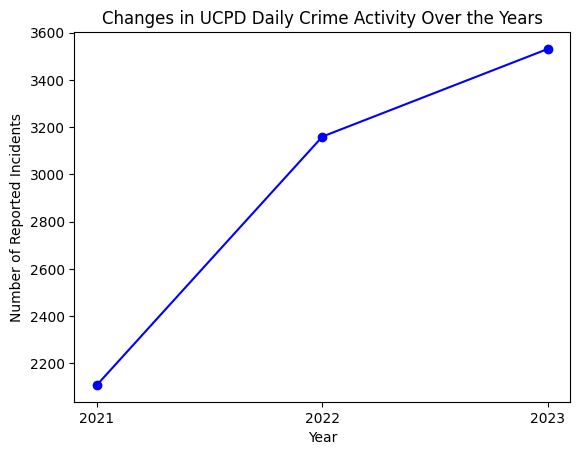

In [ ]:
# Counts of entries in the Crime Logs for each year
crime_counts = [twentyone.shape[0], twentytwo.shape[0], twentythree.shape[0]]
plt.plot([2021, 2022, 2023], crime_counts, marker='o', linestyle='-', color='b')
plt.xticks([2021, 2022, 2023])
plt.title('Changes in UCPD Daily Crime Activity Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Reported Incidents')

The following graph represents the top 10 locations mentioned in the UCPD Daily Crime Logs, between 2021 and 2023, showing most notably that all of locations are either on or in close proximity to campus.

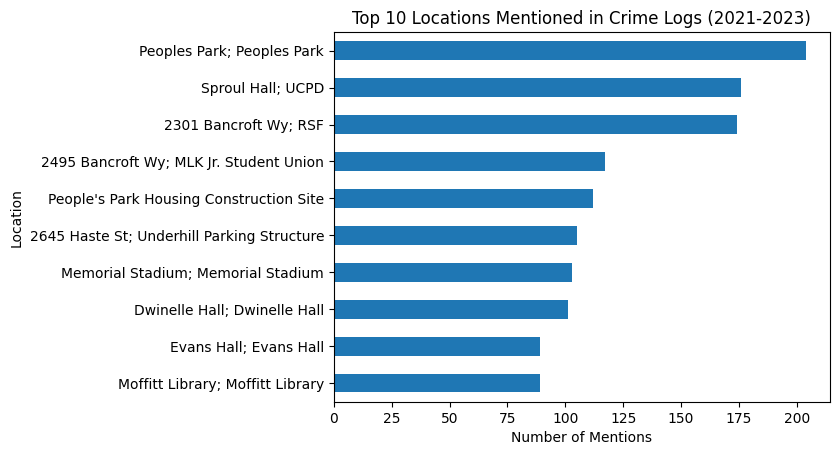

In [ ]:
# Aggregating location data from the crime logs of all years and identifying the most mentioned locations
location_counts = crimelog['Location'].value_counts().head(10)

location_counts.plot(kind='barh')
plt.title('Top 10 Locations Mentioned in Crime Logs (2021-2023)')
plt.xlabel('Number of Mentions')
plt.ylabel('Location')
plt.gca().invert_yaxis()

The final graph below compares the proportion of incident types in the WarnMe Reports and the UCPD Crime Logs. From this graph, we can see that WarnMes report a higher proportion of most incident types, but this is largely due to the fact that the "Other" category dominates so heavily, as we discussed prior.

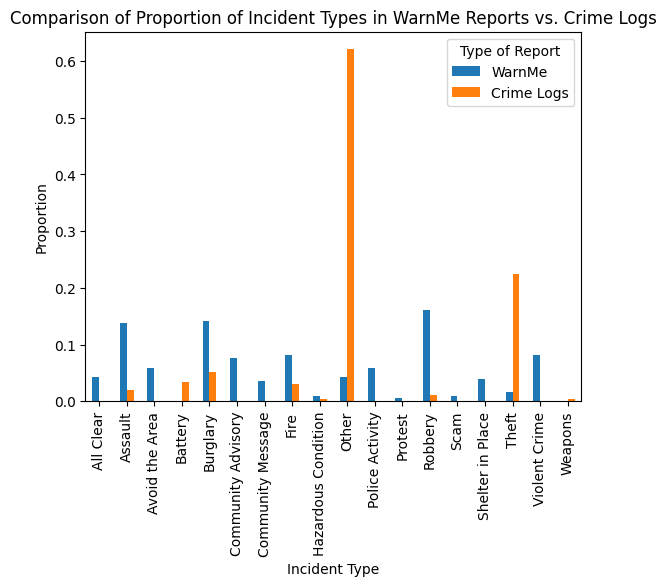

In [ ]:
# Comparison of Proportion of Incident Types in WarnMe Reports vs. Crime Logs

warnme_proportion = warnme_summary['Proportion of All Messages']
crimelog_proportion = crimelog_summary['Proportion of All UCPD Messages']

# Combine into one DataFrame
comparison = pd.DataFrame({
    'WarnMe': warnme_proportion,
    'Crime Logs': crimelog_proportion
}).fillna(0)

comparison.plot(kind='bar')
plt.title('Comparison of Proportion of Incident Types in WarnMe Reports vs. Crime Logs')
plt.ylabel('Proportion')
plt.legend(title='Type of Report')

----
# **Section 2: Modeling**

## **Matching WarnMe Alerts with UCPD Crime Log Entries**

Before we move onto modeling, we must first match each individual WarnMe alert with a UCPD Crime Log entry. For simplicity, we only need to match the most relevant incident types, which are Fire, Assault, Robbery, Burglary, Theft, Violent Crime, and Hazardous Condition, so we only include incidents of those types, and ensure that the label types match between the two datasets. As such, we group together Battery and Assault, and Weapons and Violent Crime.

In [ ]:
# Matching WarnMe notifications with crime log entries

# We only need to match events of certain incident types, eg "scam" and "protest" doesn't matter here
warnme_cats = ['Fire', 'Assault', 'Robbery', 'Burglary', 'Theft',
       'Violent Crime', 'Hazardous Condition']
warn = warnme[warnme['Incident Type'].isin(warnme_cats)].copy()
crimelog_cats = ['Battery', 'Burglary', 'Theft', 'Fire', 'Assault',
       'Weapons', 'Hazardous Condition', 'Robbery']
crime = crimelog[crimelog['Incident Type'].isin(crimelog_cats)].copy()

# Group incident types together so that they all match
crime['Incident Type'] = crime['Incident Type'].replace('Battery', 'Assault')
crime['Incident Type'] = crime['Incident Type'].replace('Weapons', 'Violent Crime')

# Clean up the DataFrame
columns_to_drop = [col for col in crime.columns if col.startswith('Unnamed')]
crime = crime.drop(columns=columns_to_drop)
crime = crime.reset_index()

Below, we match each WarnMe alert with it's corresponding Crime Log entry. To do so, we define a function called find_closest_match, which filters and identifies crime log entries that match a given WarnMe event's type and occurred within 24 hours of the WarnMe alert. If a matching entry is found, the function calculates the time difference between the WarnMe alert and the crime event, identifying the crime log entry with the smallest time difference as the closest match. The function is then applied to each WarnMe event, recording the index of the closest crime log entry and the time difference for each event. WarnMe events without a corresponding crime log entry are dropped.

Finally, the remaining matched WarnMe data is merged with the details from the corresponding crime log entries based on the closest crime indices, resulting in a combined table that includes comprehensive information from both datasets. This merged table provides a detailed view of each incident, aligning WarnMe alerts with relevant crime logs to aid in our deeper analysis via modeling.

In [ ]:
# Match each WarnMe event with the closest time stamps between WarnMe 'Sent On' and Crime 'Reported'

def find_closest_match(warn_row, crime_df):
    # Filter crimes that match the incident type of the WarnMe event
    matching_crimes = crime_df[crime_df['Incident Type'] == warn_row['Incident Type']]

    # Further filter to include only those crimes that occurred within 24 hours of the WarnMe event
    matching_crimes = matching_crimes[
        (matching_crimes['Occurred Range'] >= (warn_row['Sent On'] - pd.Timedelta(days=1))) &
        (matching_crimes['Occurred Range'] <= (warn_row['Sent On'] + pd.Timedelta(days=1)))
    ]

    if matching_crimes.empty:
        # If no crimes match the tighter time criteria, return NA
        return pd.Series({
            'Closest Crime Index': pd.NA,
            'Time Difference': pd.NA
        })

    # Calculate the absolute time difference
    time_diff = (warn_row['Sent On'] - matching_crimes['Occurred Range']).abs()

    # Find the index of the minimum time difference
    min_index = time_diff.idxmin()

    # Return the closest crime index and the time difference
    return pd.Series({
        'Closest Crime Index': min_index,
        'Time Difference': time_diff[min_index]
    })

# Apply the function to each WarnMe event
# 'Closest Crime Index' is the index of the crime that is associated with the particular warnme event
# 'Time Difference' is the difference in time between when the crime occurred vs. when the warnme was sent out
results = warn.apply(lambda row: find_closest_match(row, crime), axis=1)
warn['Closest Crime Index'] = results['Closest Crime Index']
warn['Time Difference'] = results['Time Difference']

# Drop the rows where there's no closet crime
matched = warn.dropna(subset=['Closest Crime Index'])

# Adding the corresponding crime log data to each warnme row
corresponding = matched['Closest Crime Index']
matched_crimes = crime.iloc[corresponding].reset_index()
matched_crimes = matched_crimes.drop(columns=['index', 'Index', 'level_0'])
matched_warnmes = matched.reset_index().drop(columns=['index'])

## EXPLANATION OF THE TABLES
# matched_warnmes: all of the warnme events
# matched_crimes: all of the crime log entries that correspond with each of the warnmes
# merged: all of the information about the event combined, from both the warnme data and the crime log entry
merged = pd.merge(matched_warnmes, matched_crimes)
merged

,Message Body,Message Title,Sent On,Incident Type,Date,Closest Crime Index,Time Difference,Case,Crime(s),Reported,Occurred Range,Location
0,UC Berkeley WarnMe: ALL CLEAR: Fire extinguis...,ALL CLEAR [Fire at 2500 Block of Haste Street],2021-08-19 12:41:53,Fire,2021-08-19,307,0 days 01:07:53,21-01111,FIRE: Fire,2021-08-19 11:34:00,2021-08-19 11:34:00,2538 Channing Wy
1,UC Berkeley WarnMe: ALL CLEAR: Fire extinguis...,ALL CLEAR [Fire at 2500 Block of Haste Street],2021-08-19 12:41:53,Fire,2021-08-19,307,0 days 01:07:53,21-01111,FIRE: Fire,2021-08-19 11:34:00,2021-08-19 11:34:00,2538 Channing Wy
2,UC Berkeley WarnMe: A fire has been reported a...,UC Berkeley WarnMe: Fire at Fire\nat 2500 Bloc...,2021-08-19 12:04:52,Fire,2021-08-19,307,0 days 00:30:52,21-01111,FIRE: Fire,2021-08-19 11:34:00,2021-08-19 11:34:00,2538 Channing Wy
3,UC Berkeley WarnMe: A fire has been reported a...,UC Berkeley WarnMe: Fire at Fire\nat 2500 Bloc...,2021-08-19 12:04:52,Fire,2021-08-19,307,0 days 00:30:52,21-01111,FIRE: Fire,2021-08-19 11:34:00,2021-08-19 11:34:00,2538 Channing Wy
4,Please note this message may contain informati...,Violent Crime Reported at People's Park - Plea...,2021-08-27 11:30:43,Assault,2021-08-27,335,0 days 00:20:43,21-01190,242: PC; Battery,2021-08-27 11:10:00,2021-08-27 11:10:00,Peoples Park; Peoples Park
...,...,...,...,...,...,...,...,...,...,...,...,...
172,Please note this message may contain informati...,Foothill Parking Lot - Violent Crime Reported ...,2023-08-14 14:35:46,Robbery,2023-08-14,2695,0 days 08:13:14,23-02070,OA-ROBBERY: Outside Assist - Robbery,2023-08-14 23:15:00,2023-08-14 22:49:00,Dwight Wy & College Av
173,Please note this message\nmay contain informat...,Witter Parking Lot - Violent Crime Reported - ...,2023-08-14 16:56:53,Robbery,2023-08-14,2695,0 days 05:52:07,23-02070,OA-ROBBERY: Outside Assist - Robbery,2023-08-14 23:15:00,2023-08-14 22:49:00,Dwight Wy & College Av
174,Please note this message\nmay contain informat...,Witter Parking Lot - Violent Crime Reported - ...,2023-08-14 16:56:53,Robbery,2023-08-14,2695,0 days 05:52:07,23-02070,OA-ROBBERY: Outside Assist - Robbery,2023-08-14 23:15:00,2023-08-14 22:49:00,Dwight Wy & College Av
175,Please note this message\nmay contain informat...,Witter Parking Lot - Violent Crime Reported - ...,2023-08-14 16:56:53,Robbery,2023-08-14,2695,0 days 05:52:07,23-02070,OA-ROBBERY: Outside Assist - Robbery,2023-08-14 23:15:00,2023-08-14 22:49:00,Dwight Wy & College Av


## **Timeliness Analysis**
To begin our modeling, we first perform a timeliness analysis on the dataset by analzying the varying distribution in response times across different variables, such as incidient type, time of day, and specific locations. To do so, we first identify the top 9 locations. Then, we add a column that provides the time difference between when the crime was reported and when the WarnMe alert was sent out, in minutes. With this information, we represent the distribution of time differences by incident type via a violin plot. We then categorize each incident into different parts of the day (morning, afternoon, evening, and night) based on the hour it was reported, and visualize this distribution via a violin plot as well. Finally, we use a box plot to show the distributions of time differences for the top 9 locations.

Text(0, 0.5, 'Minutes')

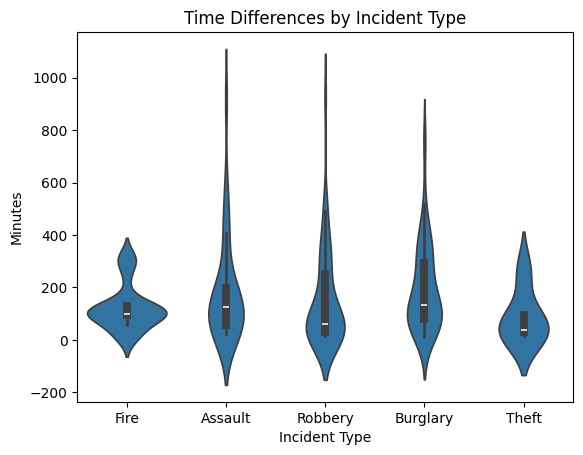

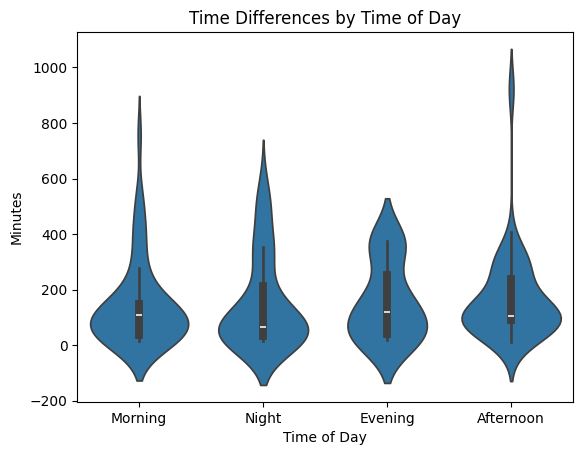

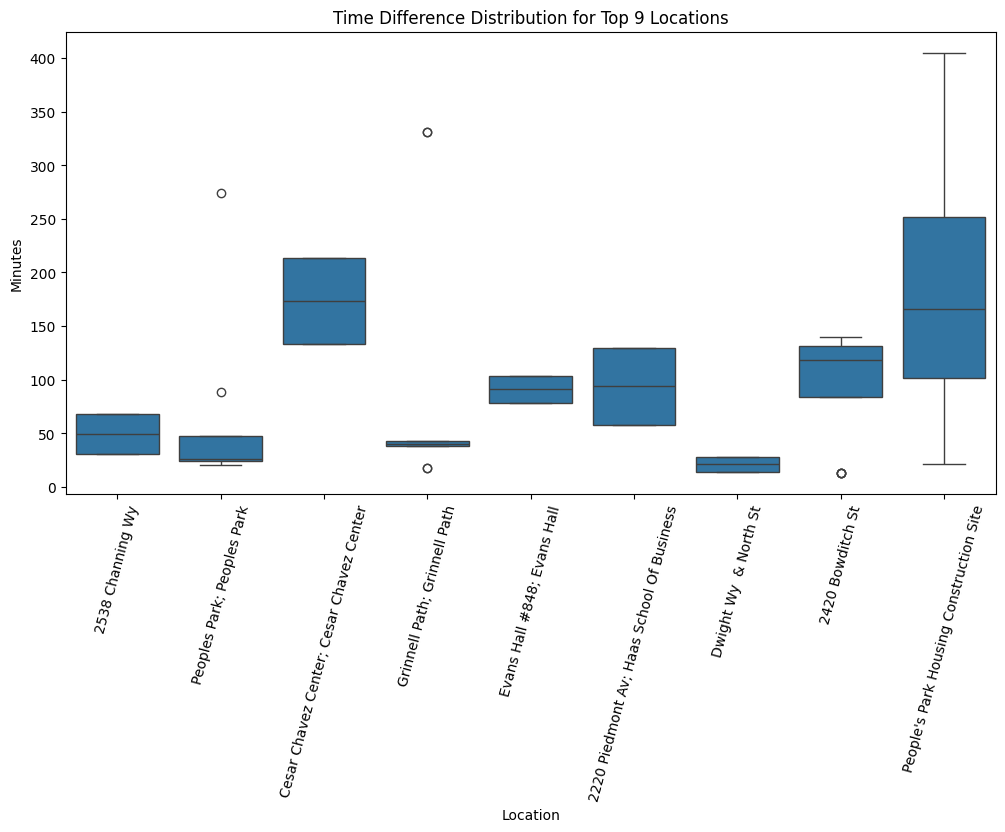

In [ ]:
# Look at only the top 9 locations
locations = merged['Location'].value_counts()
top_9_locations = ['2420 Bowditch St',
                   'Grinnell Path; Grinnell Path',
                   'Peoples Park; Peoples Park',
                   "People's Park Housing Construction Site",
                   '2538 Channing Wy',
                   'Evans Hall #848; Evans Hall',
                   'Dwight Wy  & North St',
                   'Cesar Chavez Center; Cesar Chavez Center',
                   '2220 Piedmont Av; Haas School Of Business']

# Add column that provides time difference in minutes
merged['Time Difference'] = pd.to_timedelta(merged['Time Difference'])
merged['Minutes'] = merged['Time Difference'].dt.total_seconds() / 60


# Create violin plots of time difference distribution by incident type
plt.figure()
sns.violinplot(x='Incident Type', y='Minutes', data=merged)
plt.title('Time Differences by Incident Type')
plt.xlabel('Incident Type')
plt.ylabel('Minutes')

# Categorize incidents by time of day
def time_of_day(time):
    if 5 <= time.hour < 12:
        return 'Morning'
    elif 12 <= time.hour < 17:
        return 'Afternoon'
    elif 17 <= time.hour < 21:
        return 'Evening'
    else:
        return 'Night'

merged.loc[:, 'Time of Day'] = merged['Reported'].apply(lambda x: time_of_day(x))

# Create violin plots of time difference distribution by time of day
plt.figure()
sns.violinplot(x='Time of Day', y='Minutes', data=merged)
plt.title('Time Differences by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Minutes')

# Categorize incidents by locations of interest
top_locations_df = merged[merged['Location'].isin(top_9_locations)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location', y='Minutes', data=top_locations_df)
plt.title('Time Difference Distribution for Top 9 Locations')
plt.xlabel('Location')
plt.xticks(rotation=75)
plt.ylabel('Minutes')

## **Geographical Analysis**
Our next type of analysis is looking at the geographical distribution of the reported crimes in the WarnMe logs, based off the locations pinpointed by the corresponding Crime Log information.
First, we set up and use Geocoder, which allows us to convert location names into geographic coordinates (latitude and longitude) for use in mapping later on. We create the a function to convert a given location name into coordinates.

In [ ]:
# Initialize Geocoder, which will allow us to find the coordinates of a location to plot later on
berkeley_bbox = (-122.324818, 37.846767, -122.256466, 37.892195)
geolocator = Nominatim(user_agent="my_geocoder", timeout=10)

count = 0
# Geocode locations to obtain coordinates
def geocode_location(location):
    try:
        location = geolocator.geocode(location)
        latitude, longitude = location.latitude, location.longitude

        if latitude > 40 or latitude <35:
            return None
        if longitude < -125 or longitude > 120:
            return None
        return (latitude, longitude)

    except:
        return None

Next, we find the 20 most frequently reported crime locations and list them. For each location in the list, we retrieve the coordinates using our function created earlier.

In [ ]:
# Find the most commonly reported location areas according to the crimelog
location_counts_crimelog = crimelog['Location'].value_counts().head(20)

# Based off location_counts, listed below are the most commomly occurring crime areas in the crime logs
locations_crimelog = [
    'Peoples Park; Peoples Park', 'Sproul Hall; UCPD', '2301 Bancroft Wy; RSF',
    '2495 Bancroft Wy; MLK Jr. Student Union', "People's Park Housing Construction Site",
    '2645 Haste St; Underhill Parking Structure', 'Memorial Stadium; Memorial Stadium',
    'Dwinelle Hall; Dwinelle Hall', 'Evans Hall; Evans Hall', 'Moffitt Library; Moffitt Library',
    '2401 Durant Av; Blackwell Hall', 'Valley Life Science Building; Valley Life Science Building',
    'University Village; UVA', 'Lower Sproul Garage; Lower Sproul Garage',
    '2220 Piedmont Av; Haas School Of Business', 'Golden Bear Cafe; Golden Bear Cafe',
    '2299 Piedmont Av; I House', 'Upper Sproul Plaza; Upper Sproul Plaza',
    '2415 Bowditch St; Crossroads'
]

# Create a dictionary mapping each location to its coordinates
location_coordinates_crimelog = {}

for location in locations_crimelog:
    # Geocode the location
    coordinates = geocode_location(location)

    # Add location and its coordinates to the dictionary
    location_coordinates_crimelog[location] = coordinates

location_coordinates_crimelog['Peoples Park; Peoples Park'] = 37.8658, -122.2571
location_coordinates_crimelog['Sproul Hall; UCPD'] = 37.869599999, -122.25878
location_coordinates_crimelog['2495 Bancroft Wy; MLK Jr. Student Union'] = 37.869137, -122.259614
location_coordinates_crimelog["People's Park Housing Construction Site"] = 37.8658, -122.2571
location_coordinates_crimelog['2645 Haste St; Underhill Parking Structure'] = 37.86705, -122.25492
location_coordinates_crimelog['Memorial Stadium; Memorial Stadium'] = 37.87132, 122.25060
location_coordinates_crimelog['Valley Life Science Building; Valley Life Science Building'] = 37.871479999999998, -122.262110
location_coordinates_crimelog["University Village; UVA"] = 37.874536, -122.262077
location_coordinates_crimelog['Golden Bear Cafe; Golden Bear Cafe'] = 37.87044946222455, -122.26059079515606
location_coordinates_crimelog['2299 Piedmont Av; I House'] = 37.87012417898413, -122.25214633253236

Here, we create two functions: one that will locate whether we have already stored the location, and if not, will use the geocode_location function to store the location. The other returns the string after 'at' to find the location of an incident. We use this function to create a new 'location' column.

In [ ]:
# Create a function that will locate whether we have already stored the location; else, use the geocode_location function
def find_coordinates(location, location_coordinates):
  if location in location_coordinates:
    return location_coordinates.get(location)
  else:
    coords = geocode_location(location)
    location_coordinates[location] = coords

In [ ]:
# Define a function that will return the string after 'at' to find the location
def string_from_at(input_string):
    # Find the index of "at"
    if isinstance(input_string, str):
      match = re.search(r'\bat\b', input_string)

      if match:
            index = match.start()
        # If "at" is not found, return an empty string
      else:
            return None

    else:
      return None

    # Start the substring from the position after "at"
    substring_start = index + 2

    # Find the index of "-" after "at", if exists
    index_of_dash = input_string.find("-", substring_start)

    # If "-" is found after "at", return the substring from "at" to "-"
    if index_of_dash != -1:
        return input_string[substring_start:index_of_dash]

    # If "-" is not found, return the substring from "at" to the end of the string
    return input_string[substring_start:]

# Apply the function to create the new 'location' column
warnme['Location'] = warnme['Message Title'].apply(lambda x: string_from_at(x))

# Only keep the rows where Location has values
warnme_locations_cleaned = warnme[pd.notnull(warnme['Location'])]

Then, we grab all of the unique locations, and for each location, we store its coordinates, filtering out rows where there are no coordinates. Finally, we generate a heatmap of the data, visualizing the density of the WarnMe alerts based on their locations.

In [ ]:
# Grab all the unique locations
unique_locations = warnme_locations_cleaned['Location'].unique().tolist()
print(len(unique_locations))

# Create a dictionary mapping each location to its coordinates
location_coordinates_warnme = {}

for location in unique_locations:
    # Geocode the location
    coordinates = geocode_location(location)

    # Add location and its coordinates to the dictionary
    location_coordinates_warnme[location] = coordinates

114


In [ ]:


locs = warnme_locations_cleaned['Location']
warnme_locations_cleaned['coordinates'] = locs.apply(find_coordinates, location_coordinates=location_coordinates_warnme)

# Filter rows where 'Coordinates' column has data
warnme_locations_cleaned = warnme_locations_cleaned.copy()[pd.notnull(warnme_locations_cleaned['coordinates'])]

# Create a folium map centered around the mean of coordinates
berkeley_coords = (37.8716, -122.2727)
berkeley_map = folium.Map(location=berkeley_coords, zoom_start=15)

# Extract latitude and longitude into separate columns
coordinates_df = pd.DataFrame(warnme_locations_cleaned['coordinates'].tolist(), columns=['latitude', 'longitude'], index=warnme_locations_cleaned.index)
warnme_locations_cleaned['latitude'] = coordinates_df['latitude']
warnme_locations_cleaned['longitude'] = coordinates_df['longitude']

# Convert coordinates to list of lists
heat_data = warnme_locations_cleaned[['latitude', 'longitude']].values.tolist()

# Add heatmap layer to the map
HeatMap(heat_data).add_to(berkeley_map)
berkeley_map

<ipython-input-21-cf4531430514>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warnme_locations_cleaned['coordinates'] = locs.apply(find_coordinates, location_coordinates=location_coordinates_warnme)


We then do the same, but for the Crime Log entries.

In [ ]:
# Filter rows where 'Location' and 'Date' column has data
crimelog_clean = crimelog[pd.notnull(crimelog['Location'])]
crimelog_clean = crimelog_clean[pd.notnull(crimelog_clean['Date'])]

# Convert 'Dates' column to datetime format
converted = pd.to_datetime(crimelog_clean['Date'])
crimelog_clean['Date'] = converted

# Filter rows where the year is 2021 and the month is June
crimelog_2021 = crimelog_clean[crimelog_clean['Date'].dt.year == 2021]
crimelog_2021 = crimelog_2021[crimelog_2021['Date'].dt.month == 6]

# Filter rows where the year is 2022
crimelog_2022 = crimelog_clean[(crimelog_clean['Date'].dt.year == 2022) & (crimelog_clean['Date'].dt.month == 6)]

# Filter rows where the year is 2023
crimelog_2023 = crimelog_clean[(crimelog_clean['Date'].dt.year == 2023) & (crimelog_clean['Date'].dt.month == 6)]
crimelog_combined = pd.concat([crimelog_2021, crimelog_2022, crimelog_2023], ignore_index=True)

location_coordinates = {}
crimelog_combined['coordinates'] = crimelog_combined['Location'].apply(lambda loc: find_coordinates(loc, location_coordinates))

In [ ]:
# Filter rows where 'coordinates' column has data
crimelog_combined_fake = crimelog_combined
crimelog_combined_fake = crimelog_combined_fake[crimelog_combined_fake['coordinates'].notnull()]
crimelog_combined_fake = crimelog_combined_fake[pd.notnull(crimelog_combined_fake['coordinates'])]

# Create a folium map centered around the mean of coordinates
berkeley_coords = (37.8716, -122.2727)
berkeley_map = folium.Map(location=berkeley_coords, zoom_start=15)

# Extract latitude and longitude into separate columns
crimelog_combined_fake[['latitude', 'longitude']] = pd.DataFrame(crimelog_combined_fake['coordinates'].tolist(), index=crimelog_combined_fake.index)

# Convert coordinates to list of lists
heat_data = crimelog_combined_fake[['latitude', 'longitude']].values.tolist()

# Add heatmap layer to the map
HeatMap(heat_data).add_to(berkeley_map)
berkeley_map

## **Predictive Modeling for Incident Description Accuracy**
For the last aspect of modeling, we use predictive modeling on the description of WarnMe alerts ('Message Title'/'Message Body') to determine if the description properly matches the incident type. If the description is accurate, then the predictive model should be able to correctly categorize the alert to the right incident type.

In [ ]:
# Clearing out the few rows which had nan's listed as their Message Titles.
merged_1 = merged.copy().dropna(axis = 0)

# Tokenizing the WarnMe Message Titles.
import nltk
nltk.download('stopwords')
nltk.download('punkt')

merged_1 = merged.copy().dropna(axis = 0)
title_documents = merged_1['Message Title'].values
stop = stopwords.words('english')
punctuation = string.punctuation
stemmer = SnowballStemmer("english")

# Getting rid of more common punctuation as well as trying to filter out some location words from the tokens.
more_stops = ['--', '``', "''", "s'", "\'s", "n\'t", "...", "\'m", "-*-", "-|", 'reported','at','dwight','way','and','benvenue','ave','please','note','this',
              'message','may','contain','information','that','some','may','find','upsetting','berkeley','warnm','bancroft','univers','villag','uc','hall',
              'telegraph','st','street','evan','foothill','school','haa','hast','chan','site', 'park','cleari','bever','strawberri']

titles_tokenized = []
for i in title_documents:
  tokens = [word.lower() for word in nltk.word_tokenize(i)]
  filtered_tokens = [x for x in tokens if x not in punctuation and x not in more_stops]
  stopped_tokens = [x for x in filtered_tokens if not x in stop]
  stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
  titles_tokenized.append(stemmed_tokens)

# Tokenizing the WarnMe Message Bodies.
body_documents = merged_1['Message Body'].values
bodies_tokenized = []
for i in body_documents:
  tokens = [word.lower() for word in nltk.word_tokenize(i)]
  filtered_tokens = [x for x in tokens if x not in punctuation and x not in more_stops]
  stopped_tokens = [x for x in filtered_tokens if not x in stop]
  stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
  bodies_tokenized.append(stemmed_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now that both the Message Titles and Message Bodies have been tokenized, we moved on to implementing a LDA model which, if the WarnMe descriptions -- as denoted by their titles and bodies separately -- are accurate, should be able to spit back out topics corresponding roughly with our 7 different incident types.

In [ ]:
# Creating the applicable dictionaries to implement two separate LDA models: one for Message Titles and one for Message Bodies.
title_dictionary = corpora.Dictionary(titles_tokenized)
body_dictionary = corpora.Dictionary(bodies_tokenized)

In [ ]:
# Message Title LDA Model
title_corpus = [title_dictionary.doc2bow(text) for text in titles_tokenized]
ldamodel_titles = models.LdaModel(title_corpus,
                           id2word=title_dictionary,
                           num_topics=7,
                           chunksize=15,
                           update_every=5,
                           passes=7)

# Displaying the topic areas identified by the LDA model in a more interpretable format.
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel_titles, title_corpus, title_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.081693 -0.200592       1        1  29.657837
4     -0.342178 -0.043094       2        1  21.201834
3      0.167873 -0.115647       3        1  13.472175
1      0.160611 -0.051102       4        1  11.423467
0     -0.005813  0.279262       5        1  10.492619
2      0.125516  0.008686       6        1  10.377417
6     -0.024316  0.122487       7        1   3.374652, topic_info=         Term       Freq      Total Category  logprob  loglift
8       crime  84.000000  84.000000  Default  30.0000  30.0000
10    violent  84.000000  84.000000  Default  29.0000  29.0000
132       lot  19.000000  19.000000  Default  28.0000  28.0000
72       park  32.000000  32.000000  Default  27.0000  27.0000
15   burglari  26.000000  26.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
5        area   0.139900  34.418184   Topic7  -5.4696  -2.1165
6       avoid   0.139899  32.927526   Topic7  -5.4696  -2.0723
7       warnm   0.139894  32.927530   Topic7  -5.4696  -2.0723
45       evan   0.136059   2.760794   Topic7  -5.4974   0.3787
99       near   0.135645   5.175530   Topic7  -5.5005  -0.2528

[294 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
151       2  0.977808              01-18-
107       1  0.614034  05-02-202212:07:22
105       1  0.614168  05-02-202213:41:46
106       1  0.614074  05-02-202214:02:08
102       1  0.614074  05-02-202214:13:56
...     ...       ...                 ...
7         1  0.364437               warnm
7         2  0.607394               warnm
150       3  0.611633           way01-18-
111       6  0.573709               weill
175       3  0.889620              witter

[193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 4, 2, 1, 3, 7])

As is evident when selecting one of the seven topic circles mapped out by the title-trained LDA model, despite titles of WarnMe Messages frequently containing the incident type the body of the alert message refers to, the description of these incidents often contains more information about the location of the event than the nature of the incident itself.

In [ ]:
# Doing the same thing: implementing an LDA model for WarnMe Message Bodies.
body_corpus = [body_dictionary.doc2bow(text) for text in bodies_tokenized]

ldamodel_bodies = models.LdaModel(body_corpus,
                           id2word=body_dictionary,
                           num_topics=7,
                           chunksize=15,
                           update_every=5,
                           passes=7)

# Displaying the topic areas identified by the LDA model in a more interpretable format.
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel_bodies, body_corpus, body_dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.374501 -0.015003       1        1  27.949945
4     -0.087129  0.144344       2        1  17.843924
1     -0.081405  0.151925       3        1  13.724337
6      0.034739  0.086656       4        1  12.900900
0     -0.058504 -0.141302       5        1  10.743870
3     -0.051099 -0.130305       6        1   9.890184
5     -0.131103 -0.096314       7        1   6.946840, topic_info=         Term        Freq       Total Category  logprob  loglift
8     respond   95.000000   95.000000  Default  30.0000  30.0000
9       warnm   87.000000   87.000000  Default  29.0000  29.0000
778       lot   43.000000   43.000000  Default  28.0000  28.0000
35    suspect  114.000000  114.000000  Default  27.0000  27.0000
277     crime   44.000000   44.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
112    vehicl    5.184854   27.711376   Topic7  -4.2990   0.9908
117    colleg    3.364384    9.078200   Topic7  -4.7315   1.6743
376  outstand    2.971194    9.944830   Topic7  -4.8557   1.4588
946  sidewalk    2.453078    6.550382   Topic7  -5.0474   1.6847
28    assault    2.498015   38.478048   Topic7  -5.0292  -0.0677

[349 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
89        4  0.843844              -alway
90        4  0.843716                -use
863       1  0.897954  01-18-202317:12:17
795       6  0.696023                0331
796       6  0.696023            03:31:00
...     ...       ...                 ...
383       2  0.865958                wear
64        3  0.932107           westbound
861       6  0.954848              window
1038      5  0.953027              witter
529       2  0.825910                 yrs

[422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 7, 1, 4, 6])

Again, as is evident when selecting one of the seven topic circles mapped out by the title-trained LDA model, despite the body text of WarnMe Messages frequently containing the incident type the body of the alert message refers to, the description of these incidents often contains more information about the location of the event than the nature of the incident itself.

----
# **Section 3: Key Findings**


**Time Analysis:**

Our data analysis signifies a significant difference between the types of crimes that occur during different times during the day.
* Fire incidents have a tighter distribution and a shorter mean duration between when the event occurred and when the WarnMe alert is sent out
* Theft incidents also have a shorter mean duration, as compared to other incidents
* Incidents that occurred in the afternoon take longer to be reported in the WarnMe alerts, as compared to crimes occurring at other times
* Crimes at the Cesar Chavez Center and Peoples Park take significantly longer to be reported through a WarnMe alert
* Crimes at Dwight Way and North Street take a significantly shorter amount of time to be reported through a WarnMe alert

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Minutes')

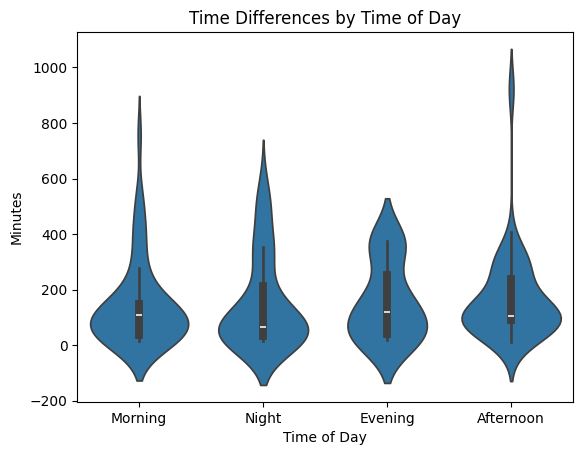

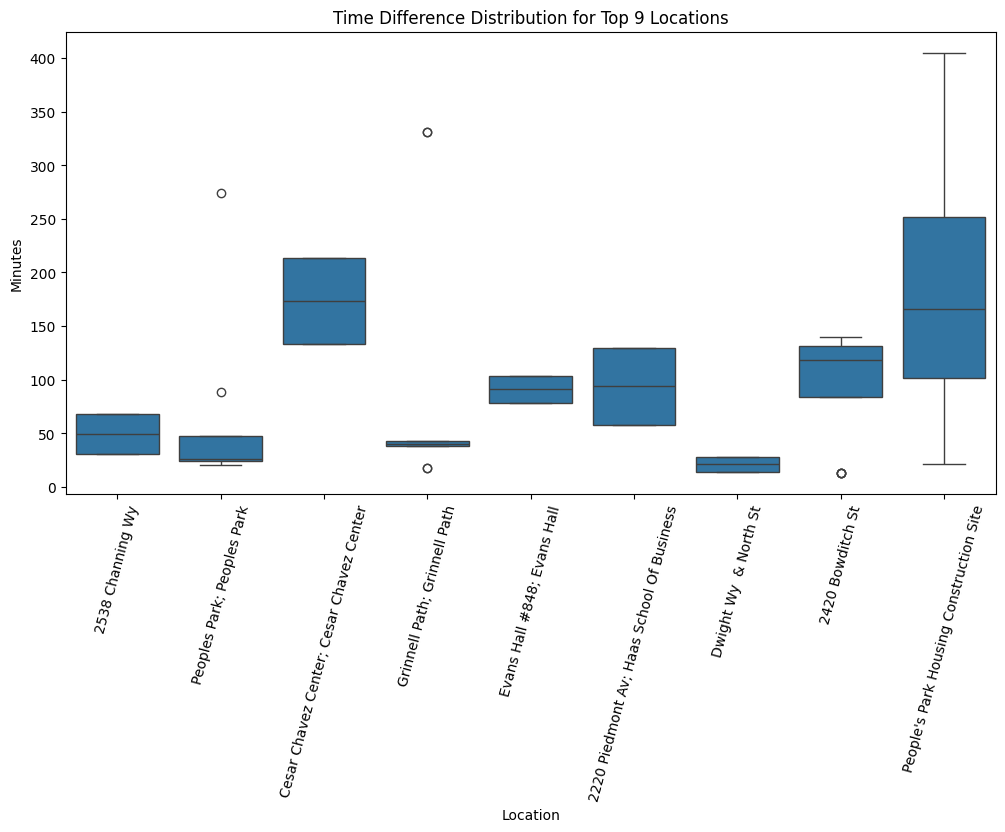

In [ ]:
# Printing for ease of reference

# Create violin plots of time difference distribution by time of day
plt.figure()
sns.violinplot(x='Time of Day', y='Minutes', data=merged)
plt.title('Time Differences by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Minutes')

# Categorize incidents by locations of interest
top_locations_df = merged[merged['Location'].isin(top_9_locations)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location', y='Minutes', data=top_locations_df)
plt.title('Time Difference Distribution for Top 9 Locations')
plt.xlabel('Location')
plt.xticks(rotation=75)
plt.ylabel('Minutes')

**Geographical Analysis:**

The heatmap displays the clusters of crime throughout Berkeley.

*   A key hot spot area depicted on the WarnMe heatmap is People's Park, otherwise known as the area along Haste St. between Bowditch and Telegraph.
  * There is no such corresponding hot spot to the same degree along the same block on the Crime Log heatmap, although there is a smaller hot spot at the corner of Channing and Bowditch.
* A hot spot of similar density to the WarnMe People's Park hot spot occurs on the Crime Log heatmap at the corner of Bancroft and Ellsworth.
  * There isn't a corresponding hot spot in this location on the WarnMe heatmap either.
*   Northside and Downtown areas also dispay scattered hot spots of crime-incidents across both heatmaps.
* Most of the incidents recorded in both heatmaps are centered generally on campus, within a general radius of 3-4 blocks.
  * However, the WarnMe heatmap's approximate center is shifted slightly further southeast than the Crime Log heatmap -- presumably because of the location of student housing and WarnMe's primary target being students.
* Additional consideration: population density in Berkeley (and in the case of the WarnMe's, student population density) could also explain differential locations of the hot spots across both heatmaps.

In [ ]:
# Printing the WarnMe Heatmap for ease of reference

berkeley_coords = (37.8716, -122.2727)
berkeley_map_1 = folium.Map(location=berkeley_coords, zoom_start=15)
coordinates_df = pd.DataFrame(warnme_locations_cleaned['coordinates'].tolist(), columns=['latitude', 'longitude'], index=warnme_locations_cleaned.index)
warnme_locations_cleaned['latitude'] = coordinates_df['latitude']
warnme_locations_cleaned['longitude'] = coordinates_df['longitude']
heat_data = warnme_locations_cleaned[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(berkeley_map_1)
berkeley_map_1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'warnme_locations_cleaned' is not defined

In [ ]:
# Printing the Crime Log Heatmap for ease of reference.

berkeley_coords = (37.8716, -122.2727)
berkeley_map_2 = folium.Map(location=berkeley_coords, zoom_start=15)
crimelog_combined_fake[['latitude', 'longitude']] = pd.DataFrame(crimelog_combined_fake['coordinates'].tolist(), index=crimelog_combined_fake.index)
heat_data = crimelog_combined_fake[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(berkeley_map_2)
berkeley_map_2

**Predictive Modeling for Incident Description Accuracy:**

The LDA models implemented on WarnMe alerts' titles and body texts were attempting to predict the topics discussed within the whole corpus of messages. Our hypothesis was that the more accurate WarnMe messages were in describing the type of incident that occurred, the better said models would be able to predict topic pools in accordance with each of the seven incident types (Fire, Assault, Robbery, Burglary, Theft, Violent Crime, and Hazardous Condition).

As even an inadequate model can tell us something about the data, here are our takeaways from the two LDA models implemented:

* The LDA models as implemented were unable to predict clear-cut topics in accordance with each of the seven incident types.
* This indicates perhaps that the information contained in WarnMe alerts is focused on location rather than accuracy about the type of incident that occurred.
  * A higher proportion of commonly used tokens/words identified in the LDA models' visualizations are related to location rather than to type of crime committed.
* This could indicate that:
  1.   The WarnMe messages are ineffective and inaccurate in terms of communicating the type of crimes committed in Berkeley.
  2.  The WarnMe messages in the current sample contain too much location information relative to incident-related information for the LDA to effectively develop incident-specific topics.
  3.  LDA models are not the correct choice for predicting topics within our specific data set.

**Potential Improvements to the WarnMe System:**

Rather than focusing on region/location of crime, an improved WarnMe model should pay more attention to the urgent nature of the crime, which can disassociate the link between crime and location bias, as well as ensuring that those within the area of a serious crime-incident receive any assistance they may need efficiently. The system can also be engineered to alert people based on population activity during time of day. When basing WarnMe messages off of day-to-day population traffic, people will be more likely to be alerted of crimes based off what times they are most likely to be effected by them.

----
## **Attribution List**

### Proposal
* **Lauren**: Emailed the UCPD to collect the WarnMe and Crime Log data; Wrote about the UCPD Crime Log data, WarnMe data, and raw data from the DailyCal article, all in the Data section; Rewrote the proposal for resubmission
* **Lili**: Wrote about the DailyCal Timeliness of WarnMe article in the References section; Wrote about the UCPD Crime Mapping in the Data section
* **Miranda**: Found the Clery Act resource and wrote about it in the References section
* **Anna**: Wrote about the 2023 Annual Security and Fire Safety Report in the References section; Found the "Risk Terrain Modeling Methods" resource and wrote about it in the References section
* **Elen**: Found the "A Bay Area Local News Article Describing Potential Issues with WarnMe Reporting" resource and wrote about it in the References section

### Exploratory Data Analysis
* **Lauren**: Delegated the split of work; Convert the WarnMe data into an excel sheet and perform all the necessary cleaning; Create a summary table that clearly identifies the outcome variables and gives descriptive statistics for the variables in the WarnMe dataset; After submitting EDA, went back and corrected Elen's visualizations and main takeaways to graph the correct data
* **Lili**: Convert the 2021-2023 Crime Log data into excel sheets and perform all necessary cleaning
* **Miranda**: Create a summary table that clearly identifies the outcome variables and gives descriptive statistics for the variables in the Crime Log dataset
* **Anna**: Create a correlation matrix or contingency table that describes the relationship between the variables in the two datasets
* **Elen**: Create a brief list of the main takeaways from the EDA and at least three visualizations that will help your audience understand your data. Include information about the distribution of word counts and time of day the message has been sent out.

### Modeling
* **Lauren**: Delegated the split of work; Matched the events in the WarnMe to the Crime Logs, then calculated the time difference between 'When it occurred' (crime logs) and 'Sent On' (WarnMe records) for each event; Created a new table combining the two tables, so that each row represented one WarnMe event and had both the WarnMe data and corresponding Crime Log data for that event
* **Lili**: Geographical analysis by  looking at the geographical distribution of the reported crimes in the WarnMe logs, based off the locations pinpointed by the corresponding Crime Log information.
* **Miranda**: Timeliness analysis by evaluating if the time-to-alert differs significantly by crime type, location, or time of day.
* **Anna**: Evaluated the accuracy of crime reporting descriptions by using predictive modeling on 'Message Title'/'Message Body' (WarnMe records) to determine if the description properly matches the incident type (eg is the description accurate?); Helped Elen with her part as well
* **Elen**: Summarize the main results from each analysis, then discuss how these findings interact with one another. Identify any patterns or anomalies and address the extent to which WarnMe alerts reflect the actual criminal activity around the Berkeley campus. Then, make suggestions regarding potential improvements to the system. Had help from Anna on her part.

### Project Notebook
* **Lauren**: Delegated the split of work; Wrote the short markdown cells between cells of code to help the reader understand what's going on; Compiled the attribution list
* **Anna**: Wrote the brief report of the question under investigation, why the question is important, how we went about answering the question, and the conclusions we were able to draw from the data

### Web Presentation
* **Lauren**: Wrote the Introduction and Data explanations
* **Lili**: Wrote about the Geographical section
* **Miranda**: Wrote about the Timeliness of WarnMes
* **Elen**: Wrote the Conclusion and Predictive Modeling sections